# Set up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re, string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tensorflow import keras
from keras.utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from PIL import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Use image hashes for prediction

Check to see if image hashes can be used to predict label groups for the test dataset.

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_translated.csv')

In [ ]:
# function to check the matching of image_phash in 2 dataset
def check_phash(test_df, train_df):

  # merge label_group from train_df into test_df only on rows
  # where image_phash from train_df also exist in test_df
  merged_df = pd.merge(test_df, train_df[['image_phash', 'label_group']],
                       on = 'image_phash', how = 'inner')

  # group merge_df by image_phash and aggregate the label_group as a list
  # resulting dataframe has 2 columns:
  # image_phash and label_group (containing a list of label_group with the same image_phash)
  grouped_df = merged_df.groupby('image_phash',
                                 group_keys = True)['label_group'].apply(list).reset_index()

  # combine test_df with the new column containing
  # lists of label_groups with the same image_phash
  test_match = test_df.copy()
  test_match = pd.merge(test_match, grouped_df,
                          on = 'image_phash', how = 'left')
  test_match.rename(columns = {'label_group': 'matching_labels'},
                    inplace = True) # rename label_group to matching_labels


  # check if any NA value in matching_labels column
  if test_match['matching_labels'].isna().any():

    # if yes, not all image_phashes in test_df have matching in train_df
    # unable to predict label_group in test_df with image_phash
    # return the records in test_df that need a model to predict label_group
    non_null_mask = test_match['matching_labels'].notnull()
    phash_nomatch = test_match.drop(index = test_match[non_null_mask].index)

    print('\033[1mCannot find label groups for these records.\nPlease use model for prediction\033[0m\n')

    return phash_nomatch

  else:

    # if no, all image_phashes in test_df have matching in train_df
    # image_phashes can be used to predict label_group in test_df
    # return the label_group prediction in a dataframe
    phash_match = test_match.dropna(subset=['matching_labels'])

    print('\033[1mAll image hashes have been matched with appropriate label groups.\nPlease proceed to look for matching posting ids\033[0m\n')

    return phash_match

In [ ]:
match_result = check_phash(test_df = test_df, train_df = train_df)
match_result

Cannot find label groups for these records.
Please use model for prediction



,Unnamed: 0,posting_id,image,image_phash,title,title_translate,matching_labels
0,0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,Edufuntoys - CHARACTER PHONE has lights and mu...,NaN
1,1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,(Buy 1 Free Spatula) Blackhead Mask | Blackhea...,NaN
2,2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,READY Lemonilo Healthy instant noodle soup and...,NaN


# Use model for prediction

## Load model

Loading the trained TF-IDF - CNN model that takes both titles and images as inputs to predict the label groups

In [ ]:
model = keras.models.load_model('final_model.h5')

## Load data

### Datasets

In [ ]:
# train
train = pd.read_csv('final_train.csv')
train.set_index(train.columns[0], inplace = True)
train.index.name = None
train.head(3)

,posting_id,image,image_phash,title,label_group,title_translate
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,Victoria's Secret Paper Bag
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,Double Tape 3M VHB 12 mm x 4.5 m ORIGINAL / DO...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,Maling TTS Canned Pork Luncheon Meat 397 gr


In [ ]:
# validation
validation = pd.read_csv('final_validation.csv')
validation.set_index(validation.columns[0], inplace = True)
validation.index.name = None
validation.head(3)

,posting_id,image,image_phash,title,label_group,title_translate
11443,train_1003554842,560a5c3577fb22be2ac82c0e97558158.jpg,f3c78fce8c3050f0,Mustika Ratu Minyak Cem-Ceman 175 ml,3044373336,Mustika Ratu Oil Cem-Ceman 175 ml
29516,train_523363809,dd1f14c7a734ff28b67062ae4f8529c6.jpg,af919a66c49d688b,Snobby Kelambu Box Bayi Snobby 1 Tiang KBX 1201,873493898,Snobby Baby Mosquito Net Snobby 1 Pole KBX 1201
6976,train_1036373061,34b4aa697f4606fcf52ec74f53c9f246.jpg,dc132bece40552db,stopper mini,578575602,mini stoppers


In [ ]:
# test
test = match_result.copy()
test.set_index(test.columns[0], inplace = True)
test.index.name = None
test.drop(['matching_labels'], axis = 1, inplace = True)
test.head()

,posting_id,image,image_phash,title,title_translate
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,Edufuntoys - CHARACTER PHONE has lights and mu...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,(Buy 1 Free Spatula) Blackhead Mask | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,READY Lemonilo Healthy instant noodle soup and...


### Test Images

Load the test images as numpy arrays

In [ ]:
# define a function to load the images and convert them to numpy arrays
path = 'kaggle/test_images/'

def load_image(file_name):
    img = Image.open(path + file_name)
    fixed_size = (64, 64) # set the desired fixed size
    img = img.resize(fixed_size)
    img_array = np.array(img)
    return img_array

In [ ]:
# apply the load_image function to the test images
test['image_array'] = test['image'].apply(lambda x: load_image(x))

In [ ]:
test['image_array'].shape

(3,)

## Pre-process Inputs

### Titles
**CLEANING**

In [ ]:
# function to clean the translated titles before embedding
def clean_title(title):
    # remove all non-alphanumeric characters and convert to lowercase
    clean1 = re.sub(r'[^a-zA-Z0-9\s]', '', title).lower()
    # split the cleaned string into words
    clean2 = re.split('\W+', clean1)
    # remove stopwords and short words
    title_cleaned = [word for word in clean2 if (word not in stopwords.words('english')) & (len(word) > 2)]
    # join the cleaned words using a space separator
    title_cleaned = ' '.join(title_cleaned)
    return title_cleaned

In [ ]:
train['title_cleaned'] = train['title_translate'].apply(clean_title)

In [ ]:
test['title_cleaned'] = test['title_translate'].apply(clean_title)

**TOKENIZATION**

In [ ]:
# define the TfidfVectorizer to transform the text input
tfidf = TfidfVectorizer()

# text_features = tfidf.fit_transform(train['title_clean'])
texts_train = train['title_cleaned']
texts_test = test['title_cleaned']
X_text_train = tfidf.fit_transform(texts_train)
X_text_test = tfidf.transform(texts_test)

In [ ]:
X_text_train.shape

(29603, 24193)

In [ ]:
X_text_test.shape

(3, 24193)

### Images

In [ ]:
# normalize the images
test['normalized_image'] = test['image_array'] / 255.0
test['normalized_image'].shape

(3,)

In [ ]:
# reshape
X_image_test = np.array(test['normalized_image'].tolist())

In [ ]:
X_image_test.shape

(3, 64, 64, 3)

## Prediction

Using the pre-processed inputs (titles and images) to predict the label_group

In [ ]:
# predict on test data
prediction = model.predict([X_image_test, X_text_test.toarray()])

1/1 [==============================] - 1s 619ms/step


## Post-process Ouputs

Since the outputs of the model are one-hot encoded label_group, they will need to be decoded back to the original form.

In [ ]:
# combine the train and validation set to ensure consistent encoding
combined_df = pd.concat([train, validation])
combined = combined_df['label_group']

In [ ]:
# create mapping between integer label groups and their original forms from one-hot encoding
le = LabelEncoder()

# convert label groups to integers
labels_int = le.fit_transform(combined)

# one-hot encode the label groups
y = to_categorical(labels_int)

# mapping dictionary
int_to_label = {i: label for i, label in enumerate(le.classes_)}

# convert the mapping dictionary to a dataframe
int_to_label_df = pd.DataFrame(list(int_to_label.items()), columns=['Encoded Label', 'Original Label'])

# print the mapping dataframe
print(int_to_label_df)

       Encoded Label  Original Label
0                  0          258047
1                  1          297977
2                  2          645628
3                  3          801176
4                  4          887886
...              ...             ...
11009          11009      4292154092
11010          11010      4292520070
11011          11011      4292939171
11012          11012      4293276364
11013          11013      4294197112

[11014 rows x 2 columns]


In [ ]:
# ddd the predicted label groups in intergers and their confidence levels into the test_pred dataset
test_pred = test.loc[:, ['posting_id', 'image', 'image_phash', 'title_translate']]

test_pred["label_pred_int"] = np.argmax(prediction, axis=1) # decode to interger
test_pred["CL"] = np.max(prediction, axis = 1)

test_pred

,posting_id,image,image_phash,title_translate,label_pred_int,CL
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE has lights and mu...,2602,0.094924
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Buy 1 Free Spatula) Blackhead Mask | Blackhea...,7891,0.088755
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Healthy instant noodle soup and...,3427,0.091190


In [ ]:
# decode predicted label group from integers to their original forms
test_pred['label_group_pred'] = [int_to_label[i] for i in test_pred['label_pred_int']]
test_pred

,posting_id,image,image_phash,title_translate,label_pred_int,CL,label_group_pred
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE has lights and mu...,2602,0.094924,993561200
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Buy 1 Free Spatula) Blackhead Mask | Blackhea...,7891,0.088755,3058128663
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Healthy instant noodle soup and...,3427,0.091190,1330267064


## Image Check

Check the training images that have the same label group as the predicted ones.



In [ ]:
# check the training images of these label groups
path = 'train_images/'

In [ ]:
test_pred['label_group_pred']

0     993561200
1    3058128663
2    1330267064
Name: label_group_pred, dtype: int64

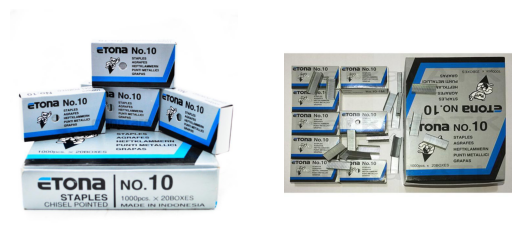

In [ ]:
# plot test images
plt.figure(figsize = (10, 6))

df = combined_df[combined_df['label_group'] == 993561200]

# loop through all records in df
for m in range(len(df)):
  plt.subplot((len(df)//3) + 1, 3, m + 1)

  # get the image
  img_path = path + df['image'].iloc[m]
  plt.axis('off')
  img = plt.imread(img_path) # plot the image
  plt.imshow(np.asarray(img))

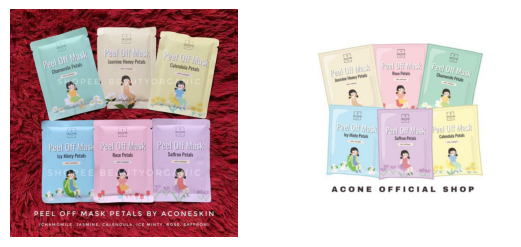

In [ ]:
# plot test images
plt.figure(figsize = (10, 6))

df = combined_df[combined_df['label_group'] == 3058128663]

# loop through all records in df
for m in range(len(df)):
  plt.subplot((len(df)//3) + 1, 3, m + 1)

  # get the image
  img_path = path + df['image'].iloc[m]
  plt.axis('off')
  img = plt.imread(img_path) # plot the image
  plt.imshow(np.asarray(img))

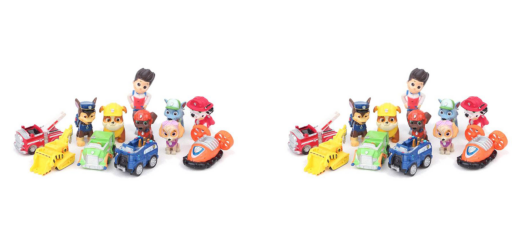

In [ ]:
# plot test images
plt.figure(figsize = (10, 6))

df = combined_df[combined_df['label_group'] == 1330267064]

# loop through all records in df
for m in range(len(df)):
  plt.subplot((len(df)//3) + 1, 3, m + 1)

  # get the image
  img_path = path + df['image'].iloc[m]
  plt.axis('off')
  img = plt.imread(img_path) # plot the image
  plt.imshow(np.asarray(img))

In [ ]:
df1 = train[train['label_group'] == 993561200]
df1

,posting_id,image,image_phash,title,label_group,title_translate,title_cleaned
2080,train_426195351,10043b865221828b6d41d601cbf205ae.jpg,afe5901a9ab5c16a,ISI STAPLES ETONA NO.10 stapler steples hekter...,993561200,ISI STAPLES ETONA NO.10 stapler staples hekter...,isi staples etona no10 stapler staples hekter ...
34081,train_3436898021,feb4041f8ae80718347e9d8b796ded2f.jpg,cee6b059932e1cb1,isi staples etona no 10,993561200,fill in staples etona no 10,fill staples etona


In [ ]:
df2 = train[train['label_group'] == 3058128663]
df2

,posting_id,image,image_phash,title,label_group,title_translate,title_cleaned
5551,train_4243420357,29ea7463620c0e76d31bfa3f796d8d24.jpg,95917a886a2f6e6c,[Free Spatula Min Beli 5] Peel Off Mask Petal ...,3058128663,[Free Spatula Min Buy 5] Peel Off Mask Petal 1...,free spatula min buy peel mask petal 10gr acon...
14253,train_559372785,6b2ebc478318b06a385a12c44e129b8d.jpg,ea6b87b494896a4b,[GROSIR] 10gr Peel Off Mask with Petal Masker ...,3058128663,[WHOLESALE] 10gr Peel Off Mask with Petal Peta...,wholesale 10gr peel mask petal petal peel mask...


In [ ]:
df3 = train[train['label_group'] == 1330267064]
df3

,posting_id,image,image_phash,title,label_group,title_translate,title_cleaned
11069,train_2093689294,53398a9363e6ff2f251c279c47d85f4e.jpg,e68d9d2739d86605,[Bayar di Tempat]12Pcs/Set Mainan Action Figur...,1330267064,[Pay on the spot]12Pcs/Set Mini Paw Patrol Kar...,pay spot12pcsset mini paw patrol karate action...
26405,train_1187044476,c5936f27b0bfe8ebc4af8be7eb29b735.jpg,e68d9d2739d86605,Set Paw Patrol Action Figure / Pajangan mainan...,1330267064,Paw Patrol Action Figure Set / Display toys 12...,paw patrol action figure set display toys pcs


In [ ]:
# load prediction dataset
test_df = test_pred

In [ ]:
# create a dictionary with train dataset where keys are label groups and values are posting_ids
train_dict = {}
for i, row in train_df.iterrows():
    if row['label_group'] not in train_dict:
        train_dict[row['label_group']] = [row['posting_id']]
    else:
        train_dict[row['label_group']].append(row['posting_id'])

In [ ]:
# print the first 10 keys and values of train_dict
count = 0
for key, value in train_dict.items():
    print(key, value)
    count += 1
    if count == 10:
        break

249114794 ['train_129225211', 'train_2278313361']
2937985045 ['train_3386243561', 'train_3423213080']
2395904891 ['train_2288590299', 'train_3803689425']
4093212188 ['train_2406599165', 'train_3342059966']
3648931069 ['train_3369186413', 'train_921438619']
2660605217 ['train_2464356923', 'train_2753295474', 'train_305884580']
1835033137 ['train_1802986387', 'train_1396161074', 'train_713073906', 'train_1275191373', 'train_2490201622', 'train_2411544001', 'train_1859060005']
1565741687 ['train_1806152124', 'train_3227306976']
2359912463 ['train_86570404', 'train_2837452969', 'train_77364776']
2630990665 ['train_831680791', 'train_3031035861']


In [ ]:
# create a list of tuples containing posting_id from test dataset and matching posting_ids from train dataset
matching_posting_ids = []
for i, row in test_df.iterrows():
    matching_posting_ids.append((row['posting_id'], train_dict.get(row['label_group_pred'], [])))

In [ ]:
# create a new dataframe from the list of tuples
result_df = pd.DataFrame(matching_posting_ids, columns=['posting_id_test', 'posting_id_train'])

result_df.head()

,posting_id_test,posting_id_train
0,test_2255846744,"[train_426195351, train_3436898021]"
1,test_3588702337,"[train_4243420357, train_559372785]"
2,test_4015706929,"[train_2093689294, train_1187044476]"


In [ ]:
# save the result to a new csv file
result_df.to_csv('submission.csv', index=False)